In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
data_dir = './datasets/'
result_dir = './results/'
data_cleaned = pd.read_pickle(data_dir + '/data_cleaned.pkl')

crys_abbr = {
    'hexagonal': 'hex',
    'tetragonal': 'tetra',
    'orthorhombic': 'ortho',
    'monoclinic': 'mono'
}

## Plot formation energy distribution

Text(0, 0.5, '')

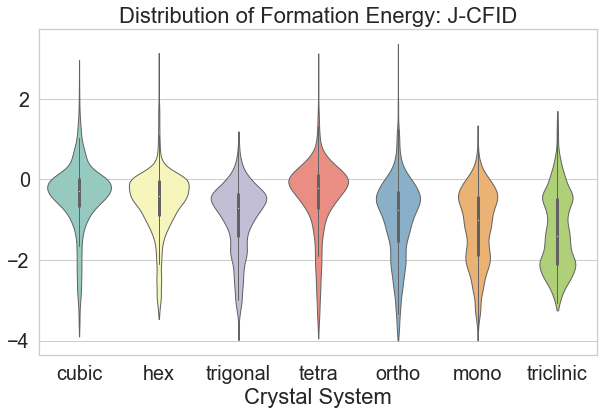

In [6]:
jarvis_abbr = data_cleaned.replace(crys_abbr)

sns.set(font_scale=1.8, style='whitegrid')
fig, ax = plt.subplots(figsize=(10,6))
large_font = {'fontsize':22}
order = ['cubic', 'hex', 'trigonal', 'tetra', 'ortho', 'mono', 'triclinic']
sns.violinplot(data=jarvis_abbr, x='crys', y='formation_energy_peratom', palette='Set3', bw=.2, cut=1, linewidth=1, order=order)
# ax.set(ylim=(-.7,2))
plt.title('Distribution of Formation Energy: J-CFID', fontdict=large_font)
plt.xlabel('Crystal System', fontdict=large_font)
plt.ylabel('')

Text(0.5, 0, 'Crystal System')

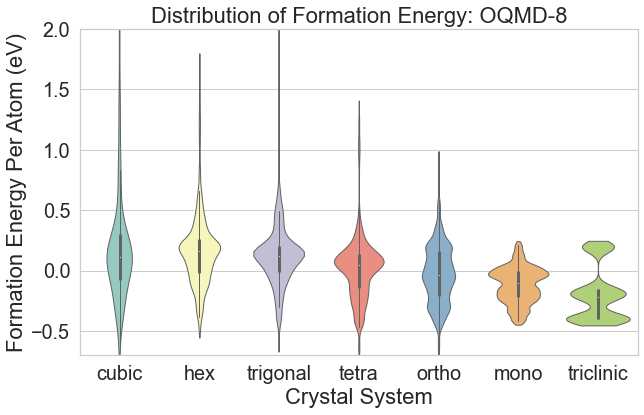

In [8]:
OQMD_data = pd.read_csv(data_dir + 'OQMD_xtalsys.csv')
OQMD_abbr = OQMD_data.replace(crys_abbr)
sns.set(font_scale=1.8, style='whitegrid')
fig, ax = plt.subplots(figsize=(10,6))
order = ['cubic', 'hex', 'trigonal', 'tetra', 'ortho', 'mono', 'triclinic']
sns.violinplot(data=OQMD_abbr, x='crystal_system', y='energy', palette='Set3', bw=.2, cut=1, linewidth=1, order=order)
ax.set(ylim=(-.7,2))
plt.title('Distribution of Formation Energy: OQMD-8', fontdict=large_font)
plt.ylabel('Formation Energy Per Atom (eV)', fontdict=large_font)
plt.xlabel('Crystal System', fontdict=large_font)

## Plot information entropy

In [49]:
from scipy.stats import differential_entropy
differential_entropy(data_cleaned['formation_energy_peratom'])

entropies = pd.DataFrame(columns=['OQMD-8', 'J-CFID', 'crys', 'n_oqmd', 'n_jarvis', 'symmetry'])
entropies['crys'] = ['cubic', 'hexagonal', 'trigonal', 'tetragonal', 'orthorhombic', 'monoclinic', 'triclinic']


for id, row in entropies.iterrows():
    row['OQMD-8'] = differential_entropy(OQMD_data[OQMD_data['crystal_system']==row['crys']]['energy'])
    row['J-CFID'] = differential_entropy(data_cleaned[data_cleaned['crys']==row['crys']]['formation_energy_peratom'])
    row['n_oqmd'] = np.sum(OQMD_data['crystal_system']==row['crys'])
    row['n_jarvis'] = np.sum(data_cleaned['crys']==row['crys'])

entropies['symmetry'] = [7,6,5,4,3,2,1]

entropies_abbr = entropies.replace(crys_abbr)

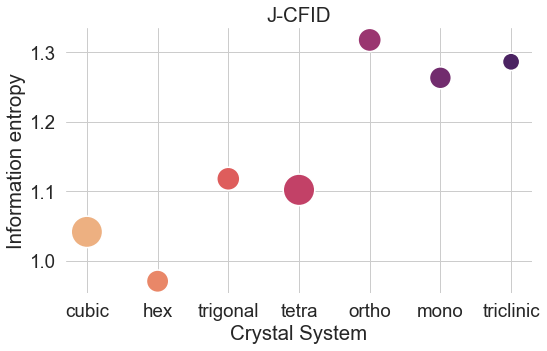

In [52]:
sns.set_theme(style='whitegrid', font_scale=1.7)
sns.relplot(data=entropies_abbr, x='crys', y='J-CFID', size='n_jarvis', hue='symmetry', palette='flare_r', legend=False, aspect=1.6, sizes=(300, 1000))
plt.xlabel('Crystal System')
plt.ylabel('Information entropy')
plt.title('J-CFID')
# Use semantically meaningful titles for the columns
sns.despine(left=True, bottom=True)

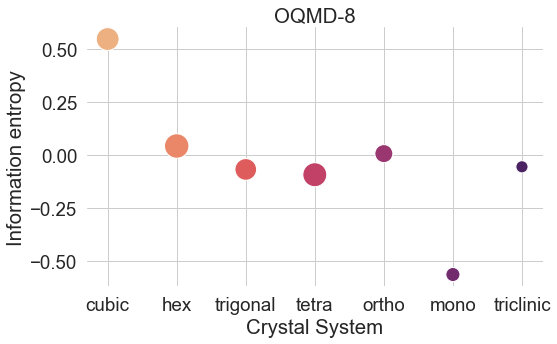

In [53]:
sns.set_theme(style='whitegrid', font_scale=1.7)
sns.relplot(data=entropies_abbr, x='crys', y='OQMD-8', size='n_oqmd', hue='symmetry', palette='flare_r', legend=False, aspect=1.6, sizes=(150, 600))
plt.xlabel('Crystal System')
plt.ylabel('Information entropy')
plt.title('OQMD-8')
# Use semantically meaningful titles for the columns
sns.despine(left=True, bottom=True)

## Post-process results
Create plots from ET-AL experiment results.

### Information entropy evolution

cubic
orthorhombic
trigonal
hexagonal
tetragonal
monoclinic
triclinic


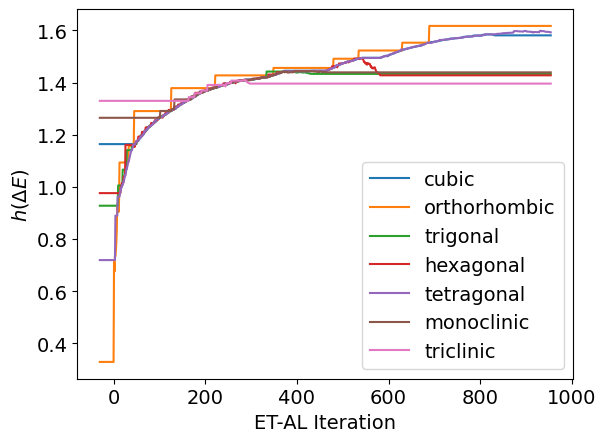

In [13]:
entropies = pd.read_csv(result_dir + 'info_entropy_evolution.csv', index_col=0)

import matplotlib
matplotlib.rc_file_defaults()
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
for col in entropies:
    ax.plot(entropies[col], label=col)
    print(col)
ax.legend(loc=4)
# plt.title('Information entropies')
plt.xlabel('ET-AL Iteration')
plt.ylabel('$h(\Delta E)$')

In [7]:
data_l_idx = np.loadtxt(result_dir + 'data_l.csv', dtype='int', delimiter=',')
data_l = data_cleaned.loc[data_l_idx]  # Labeled dataset
data_test_idx = np.loadtxt(result_dir + 'data_test.csv', dtype='int', delimiter=',')
data_test = data_cleaned.loc[data_test_idx]  # Test set
data_u = data_cleaned.drop(index=np.union1d(data_l_idx, data_test_idx), inplace=False)  # Unlabeled dataset

sample_path = np.loadtxt(result_dir + 'sample_path.csv', dtype='int', delimiter=',')
samples = sample_path[sample_path != 0]
samples_rand = data_u.sample(n=samples.shape[0], random_state=42)  # Randomly selected samples

data_l_etal_idx = np.concatenate((data_l_idx, samples)) # Two training sets
data_l_rand = pd.concat([data_l, samples_rand])

### tSNE plots
Visualization using 2D tSNE mapping of `cgcnn` features.

In [4]:
cgcnn_features =  pd.read_pickle(data_dir + 'cgcnn_embeddings.pkl').feature
cgcnn_features_test = pd.Series([np.asarray(row) for row in cgcnn_features], index=data_cleaned.index)
features = np.stack(cgcnn_features.values)

In [5]:
from sklearn.manifold import TSNE
cgcnn_tsne = TSNE(n_components=2, learning_rate='auto', perplexity=50, init='pca').fit_transform(features)
cgcnn_tsne = pd.DataFrame(cgcnn_tsne, columns=['tsne1', 'tsne2'], index=data_cleaned.index)
cgcnn_tsne['crys'] = data_cleaned['crys']

c:\Users\hzz6536\Anaconda3\envs\gp-torch\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


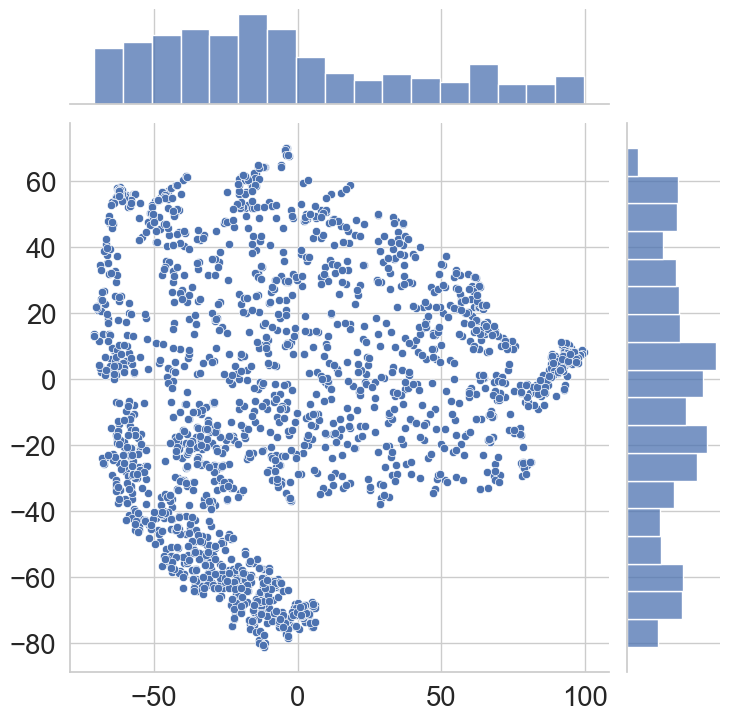

In [12]:
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
sns.set_theme(style='whitegrid', font_scale=1.8)
h = sns.jointplot(data=cgcnn_tsne.loc[data_l_etal_idx], x='tsne1', y='tsne2', height=8)
h.set_axis_labels()

Text(0.5, 1.0, 'Labeled set')

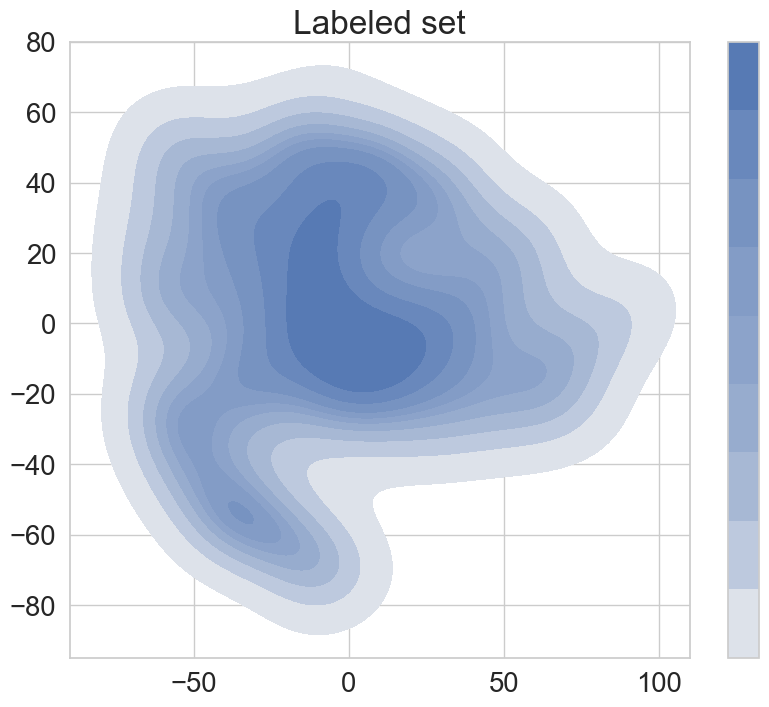

In [13]:
f, ax = plt.subplots(figsize=(10, 8))
h = sns.kdeplot(data=cgcnn_tsne.loc[data_l_idx], x='tsne1', y='tsne2', fill=True, cmap=sns.color_palette("light:b", as_cmap=True), cbar=True, cbar_kws={'ticks': []})
h.set(xlim=(-90,110), ylim=(-95,80))
plt.xlabel('')
plt.ylabel('')
plt.title('Labeled set', fontdict={'size': 24})

Text(0.5, 1.0, 'ET-AL Selected Samples')

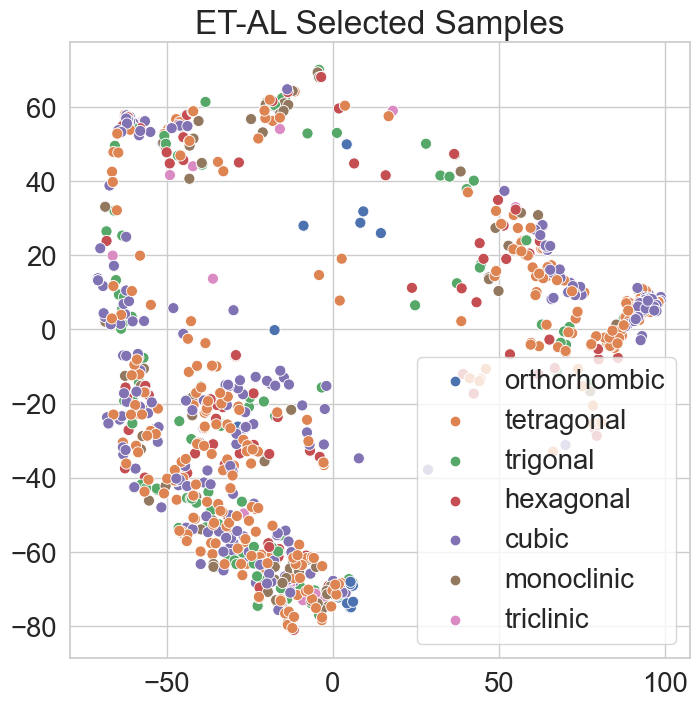

In [14]:
sns.set_theme(style='whitegrid', font_scale=1.8)
f, ax = plt.subplots(figsize=(8, 8))
hue_order = ['orthorhombic', 'tetragonal', 'trigonal', 'hexagonal', 'cubic', 'monoclinic', 'triclinic']
# hue_order = ['cubic', 'hexagonal', 'trigonal', 'tetragonal', 'orthorhombic', 'monoclinic', 'triclinic']
h = sns.scatterplot(data=cgcnn_tsne.loc[samples], x='tsne1', y='tsne2', hue='crys', hue_order=hue_order, s=64)
h.set(xlabel=None, ylabel=None)
legend = h.legend()
plt.title('ET-AL Selected Samples', fontdict={'size':24})

Text(0.5, 1.0, 'Randomly Selected Samples')

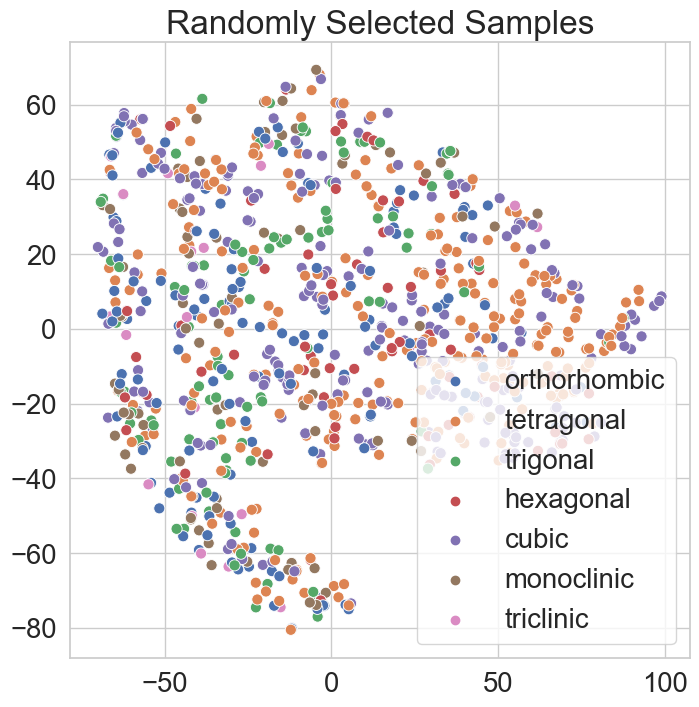

In [15]:
sns.set_theme(style='whitegrid', font_scale=1.8)
f, ax = plt.subplots(figsize=(8, 8))
h = sns.scatterplot(data=cgcnn_tsne.loc[samples_rand.index], x='tsne1', y='tsne2', hue='crys', hue_order=hue_order, s=64)
h.set(xlabel=None, ylabel=None)
legend = h.legend()
plt.title('Randomly Selected Samples', fontdict={'size':24})

### Visualize the locations of most improved samples

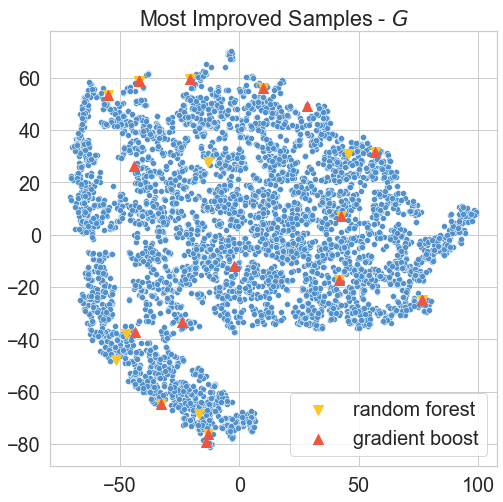

In [9]:
# Load or define most improved samples' indices: `gb_G_mis`, `gb_B_mis`, `rf_G_mis``rf_B_mis`
rf_B_mis = [23576, 34293, 34426, 46765, 23728, 14748, 30965, 28127, 43441,
            25633, 46717, 24436, 27800, 40668,  3023, 21453, 29501, 13041,
            27465, 29923]

rf_G_mis = [34293, 34426, 46765, 23728, 35229,  3023, 30202, 17481,  1356,
            24436, 34920, 13812, 24788, 30965,  2298, 50280, 14748, 28127,
            23395, 36101]

gb_B_mis = [23576, 34293, 34426, 46765, 23728, 10456, 22363, 28127, 24436,
            29923, 25633, 30965, 21453, 35106,  6712, 35229, 36656, 15755,
            29654, 23479]

gb_G_mis = [34293, 34426, 46765, 23728, 35229,  1356, 24788, 20658, 14011,
            34920,  2298, 17127, 50280, 21761, 46717, 30202, 24469, 24436,
            14761, 28127]

sns.set_theme(style='whitegrid', font_scale=1.8)
f, ax = plt.subplots(figsize=(8, 8))
h = sns.scatterplot(data=cgcnn_tsne.loc[data_test.index], x='tsne1', y='tsne2', color='#5091cd')
plt.scatter(cgcnn_tsne.loc[rf_G_mis, 'tsne1'], cgcnn_tsne.loc[rf_G_mis, 'tsne2'], marker ='v', s=100, c='#ffc520', label = 'random forest')
plt.scatter(cgcnn_tsne.loc[gb_G_mis, 'tsne1'], cgcnn_tsne.loc[gb_G_mis, 'tsne2'], marker ='^', s=100, c='#ef553f', label='gradient boost')
plt.legend(loc=4), 
h.set(xlabel=None, ylabel=None)
plt.title('Most Improved Samples - $G$')

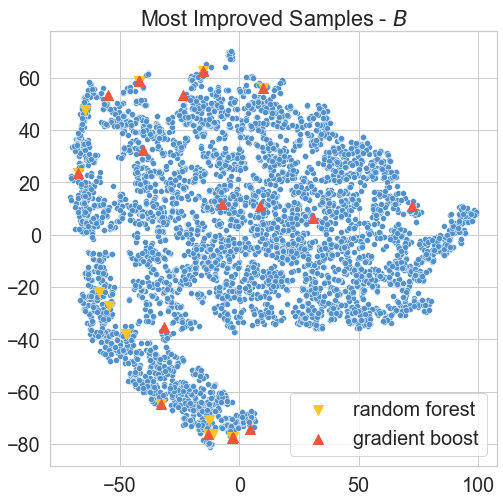

In [10]:
f, ax = plt.subplots(figsize=(8, 8))
h = sns.scatterplot(data=cgcnn_tsne.loc[data_test.index], x='tsne1', y='tsne2', color='#5091cd')
plt.scatter(cgcnn_tsne.loc[rf_B_mis, 'tsne1'], cgcnn_tsne.loc[rf_B_mis, 'tsne2'], marker ='v', s=100, c='#ffc520', label = 'random forest')
plt.scatter(cgcnn_tsne.loc[gb_B_mis, 'tsne1'], cgcnn_tsne.loc[gb_B_mis, 'tsne2'], marker ='^', s=100, c='#ef553f', label='gradient boost')

plt.legend(loc=4), 
h.set(xlabel=None, ylabel=None)
plt.title('Most Improved Samples - $B$')